In [1]:
from utils import conv
from utils import NN2hidden as nn2
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# import os
# # Load images and filenames
# train_images, train_image_filenames = dp.load_images_from_folder_filenames('rev_patching/patch_image')

# # Extract feature maps from images
# feature_maps = [fe.extract(image) for image in train_images]

# # Save feature maps with the same filenames as the original images
# for i, (feature_map, image_filename) in enumerate(zip(feature_maps, train_image_filenames)):
#     image_name = os.path.splitext(image_filename)[0]
#     pil_image = Image.fromarray(feature_map)
#     pil_image.save(f'rev_patching/feature_extract_image/{image_name}.png', format='PNG')

In [2]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/extract_ori'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [3]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.8)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.8)]

image_test = images_load[math.ceil(len(images_load)*0.8):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.8):]

In [6]:
len(feature_images_train)

2021

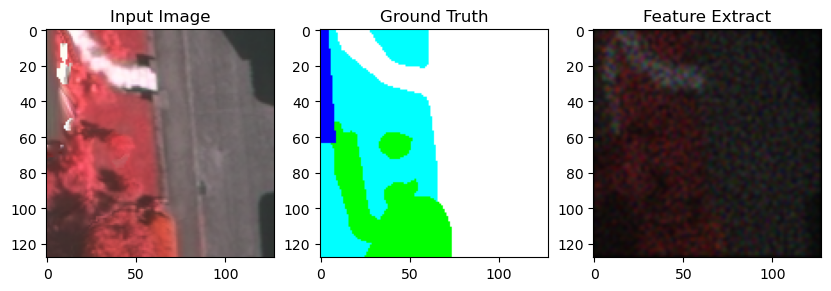

In [9]:
indeks = 1599
# Plot the images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(images_load[indeks])
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truths[indeks])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(feature_images_load[indeks])
plt.title('Feature Extract')

plt.show()

In [10]:
# Prepare data
X, y = dp.prepare_data(feature_images_train, image_label_train)

In [11]:
len(X)

3

In [12]:
# Normalize the features
X_normalized = X / 255.0

In [13]:
X_normalized.shape

(3, 33112064)

In [16]:
# Initialize the neural network
input_size = X_normalized.shape[0]
hidden_size1 = 3  # neuron hidden layer 1
hidden_size2 = 2  # neuron hidden layer 2
output_size = 2  # 2 classes: vegetation and non-vegetation
learning_rate = 0.001
num_epochs = 20
toleransi_error = 0.1

# Initialize the neural network with adjusted hidden size
model = nn2.NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Check the shape of weights_hidden_output
print(model.weights_hidden2_output.shape)

(2, 2)


In [17]:
print('Bobot dan bias sebelum training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias sebelum training:
Bobot hidden layer 1:
 [[ 1.          0.69512433 -0.94412309]
 [-0.59501192  1.         -0.14328904]
 [-1.          0.46118865 -1.        ]]
Bias hidden layer 1:
 [[0. 0. 0.]]
Bobot hidden layer 2:
 [[ 0.51961826 -0.16805729]
 [ 0.80012794  0.8582933 ]
 [-1.         -0.35668947]]
Bias hidden layer 2:
 [[0. 0.]]
Bobot output layer:
 [[-0.32043265 -1.        ]
 [-0.41854273 -0.67795701]]
Bias output layer:
 [[0. 0.]]


In [18]:
# Training loop with batching
batch_size = 128
num_batches = X_normalized.shape[1] // batch_size
losses = []
accuracies = []

threshold = 0.5  # Threshold untuk mengklasifikasikan output

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = X_normalized.shape[1]  # Total sampel dalam satu epoch
    
    for i in range(num_batches):
        # Get batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X_normalized[:, start_idx:end_idx].T
        y_batch = y[:, start_idx:end_idx].T
        
        # Forward pass
        output = model.forward(X_batch)
        
        # Compute loss
        loss = nn2.binary_cross_entropy(y_batch, output)
        epoch_loss += loss
        
        # Compute predictions based on threshold
        predicted_labels = (output >= threshold).astype(int)
        
        # Compute accuracy
        true_labels = y_batch
        correct_predictions += np.sum(predicted_labels == true_labels)
        
        # Backpropagation
        model.backward(X_batch, y_batch, learning_rate)
    
    # Average loss for the epoch
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    
    # Accuracy for the epoch
    accuracy = 1 - epoch_loss
    accuracies.append(accuracy)
    
    # Print loss
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
    
    # Early stopping
    if epoch_loss < toleransi_error:
        print("Training berhenti karena error sudah kurang dari 0.1")
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
        break

Epoch 1, Loss: 0.26175592947707277, Accuracy: 0.7382440705229272
Epoch 2, Loss: 0.2446293407896849, Accuracy: 0.7553706592103151
Epoch 3, Loss: 0.24207589107984723, Accuracy: 0.7579241089201527
Epoch 4, Loss: 0.24092790970787106, Accuracy: 0.759072090292129
Epoch 5, Loss: 0.24015574935751874, Accuracy: 0.7598442506424813
Epoch 6, Loss: 0.23958617237492713, Accuracy: 0.7604138276250729
Epoch 7, Loss: 0.23914891922431505, Accuracy: 0.760851080775685
Epoch 8, Loss: 0.23880526135427685, Accuracy: 0.7611947386457232
Epoch 9, Loss: 0.23853414403865153, Accuracy: 0.7614658559613485
Epoch 10, Loss: 0.23842664399669392, Accuracy: 0.7615733560033061
Epoch 11, Loss: 0.23836406453219258, Accuracy: 0.7616359354678074
Epoch 12, Loss: 0.23883878450853452, Accuracy: 0.7611612154914655
Epoch 13, Loss: 0.24030516305271524, Accuracy: 0.7596948369472848
Epoch 14, Loss: 0.2400769386026848, Accuracy: 0.7599230613973151
Epoch 15, Loss: 0.23994556613347995, Accuracy: 0.76005443386652
Epoch 16, Loss: 0.2398860

In [19]:
print('Bobot dan bias setelah training:')
print('Bobot hidden layer 1:\n', model.weights_input_hidden1)
print('Bias hidden layer 1:\n', model.bias_input_hidden1)
print('Bobot hidden layer 2:\n', model.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model.bias_hidden1_hidden2)
print('Bobot output layer:\n', model.weights_hidden2_output)
print('Bias output layer:\n', model.bias_hidden2_output)

Bobot dan bias setelah training:
Bobot hidden layer 1:
 [[ 13.23337894 -12.09601961   3.95210909]
 [-14.49767524  15.6079242   -5.74521368]
 [ -9.36591663   9.27557002  -4.41773435]]
Bias hidden layer 1:
 [[-0.07317444  0.39541367 -0.05177794]]
Bobot hidden layer 2:
 [[ -8.93681303 -15.95736106]
 [ 10.1394213   15.54878986]
 [ -4.3517148   -5.12555989]]
Bias hidden layer 2:
 [[0.01000377 1.48214114]]
Bobot output layer:
 [[ 1.02887723 -1.02887723]
 [-0.06315544  0.06315544]]
Bias output layer:
 [[0.10230052 0.89769948]]


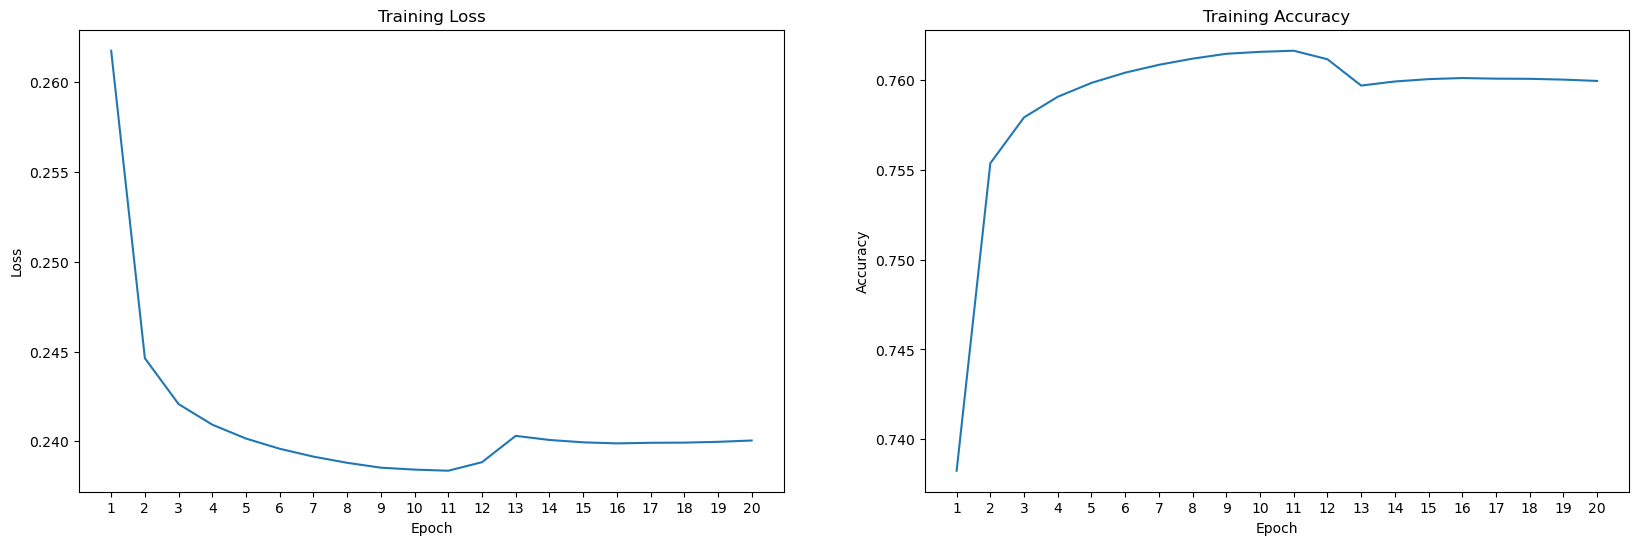

In [20]:
# Plot loss and accuracy
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)  # Menyesuaikan sumbu x
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(losses) + 1))  # Menyesuaikan nilai pada sumbu x

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies)  # Menyesuaikan sumbu x
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Menyesuaikan nilai pada sumbu x

plt.show()

In [21]:
# Save weights to a file
def save_weights(weights_hidden2_output, bias_hidden2_output, weights_hidden1_hidden2, bias_hidden1_hidden2, 
                 weights_input_hidden1, bias_input_hidden1, filename):
    with open(filename, 'wb') as f:
        np.savez(f, weights_hidden2_output=weights_hidden2_output, bias_hidden2_output=bias_hidden2_output,
                 weights_hidden1_hidden2=weights_hidden1_hidden2, bias_hidden1_hidden2=bias_hidden1_hidden2,
                 weights_input_hidden1=weights_input_hidden1, bias_input_hidden1=bias_input_hidden1)

save_weights(model.weights_hidden2_output, model.bias_hidden2_output,
             model.weights_hidden1_hidden2, model.bias_hidden1_hidden2,
             model.weights_input_hidden1, model.bias_input_hidden1,
             "4. Bobot_skenario_4.npz")

In [22]:
print(model.output)

[[ 5.60603322e-01  4.39396678e-01]
 [ 5.00714133e-01  4.99285867e-01]
 [ 8.00322157e-01  1.99677843e-01]
 [ 1.02338731e+00 -2.33873121e-02]
 [ 1.02871533e+00 -2.87153343e-02]
 [ 9.48372006e-01  5.16279941e-02]
 [ 8.77406710e-01  1.22593290e-01]
 [ 1.00880113e+00 -8.80112537e-03]
 [ 1.03512358e+00 -3.51235769e-02]
 [ 1.03838548e+00 -3.83854785e-02]
 [ 1.03169434e+00 -3.16943443e-02]
 [ 9.46048313e-01  5.39516871e-02]
 [ 8.52827835e-01  1.47172165e-01]
 [ 9.57894594e-01  4.21054060e-02]
 [ 1.02373147e+00 -2.37314684e-02]
 [ 1.03171429e+00 -3.17142854e-02]
 [ 1.02805558e+00 -2.80555771e-02]
 [ 9.69009301e-01  3.09906988e-02]
 [ 8.26277579e-01  1.73722421e-01]
 [ 7.83673173e-01  2.16326827e-01]
 [ 8.84176711e-01  1.15823289e-01]
 [ 9.81421843e-01  1.85781568e-02]
 [ 9.89193261e-01  1.08067391e-02]
 [ 9.42253134e-01  5.77468663e-02]
 [ 9.11338105e-01  8.86618948e-02]
 [ 9.41372853e-01  5.86271469e-02]
 [ 9.98358427e-01  1.64157319e-03]
 [ 1.01499220e+00 -1.49922030e-02]
 [ 1.01946489e+00 -1

before argmax 
 [[ 1.06797838 -0.06797838]
 [ 1.06797861 -0.06797861]
 [ 1.06797859 -0.06797859]
 ...
 [ 1.06798015 -0.06798015]
 [ 1.06798044 -0.06798044]
 [ 1.06798023 -0.06798023]]
after argmax 
 [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


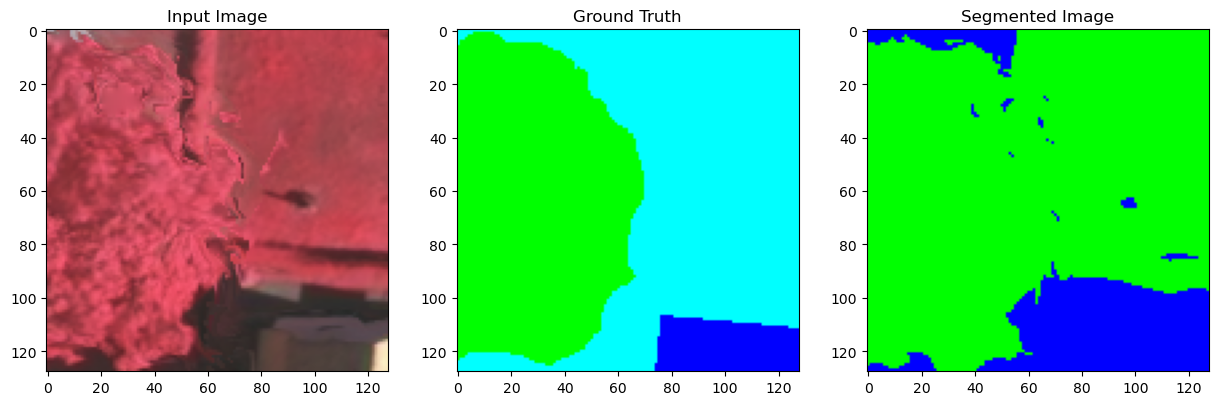

In [23]:
# Define colors for vegetation and non-vegetation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# Visualize segmentation results for one image
indexing = 2
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model.forward(features)
pred_before = predicted_mask
print('before argmax \n',pred_before)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
pred_after= predicted_mask
print('after argmax \n',pred_after)
# print(len(predicted_mask))
# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Assign colors based on predicted mask
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.show()

In [24]:
print('nilai prediksi \n', pred_before[50:60])
print('hasil argmax \n', pred_after[2][50:60])

nilai prediksi 
 [[ 0.91309717  0.08292262]
 [ 0.9657361   0.03225555]
 [ 0.99289534  0.00696309]
 [ 1.01450834 -0.01145675]
 [ 1.01434747 -0.0074396 ]
 [ 1.00350878  0.00605556]
 [ 0.99560038  0.01536018]
 [ 0.99342313  0.01787501]
 [ 0.99394047  0.01728584]
 [ 0.99504067  0.01600845]]
hasil argmax 
 [0 0 0 0 0 0 0 0 0 0]


Indeks yang ada warna merah
> 2007
> 2011 - 2013

Keperluan BI indeks analisa : 6, 19, 2012, 3192

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

=-=-=--=-=

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(2, 2, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(2, 2, 4)
plt.imshow(segmented_image)
plt.title('Segmented Image')